# COVID-19 Auswertung - Impfungen


## import libraries

In [1]:
Programm_Name = "Impfungen" # 04.01.2021 - Time Series Impffdaten erstellen

### Speicherorte und Dateinamen Plots

In [2]:
Laufwerk = "D:\\"
pfad_output = "Github\\Auswertung_Covid_19\\output\\"
pfad_onedrive = "OneDrive\\Auswertung_Covid_19\\"
pfad_input = "Github\\Auswertung_Covid_19\\input\\"

name_input = "Impfquotenmonitoring.xlsx"
name_input2 = "02-bundeslaender.xlsx"

name_7 = "plot_7_Impfquote_ger.png" # Impfquote Deutschland Bundesländer
name_7_2 = "plot_7-2_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_3 = "plot_7-3_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_4 = "plot_7-4_Impfungen_kumuliert_Timeseries_ger.png" # Impfungen Timeseries Deutschland

name_output_df_EW = 'Dataframes\\df_EW.csv'
name_output_df_I = 'Dataframes\\df_I.csv'
name_output_df_I_EW = 'Dataframes\\df_I_EW.csv'
name_output_df_I_TS = 'Dataframes\\df_I_TS.csv'

name_performance = 'Dataframes\\df_performance.csv'

### Speicherorte und Dateinamen Plots

In [3]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
import matplotlib.dates as mdates
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime, timedelta
from datetime import date # todays date
#import seaborn as sns

import os
now = datetime.now()

In [4]:
# Datum einstellen 
minticks = 14
maxticks = 14

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [5]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 25

# output größe der bilder
h = 16*1.3
v = 9
dpi = 200

 ### Bezugsgröße Einwohner

In [6]:
pE = 100_000

## Länder Farben

In [7]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_isr = '#25e5e5'
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_usa = '#bb8fce'
c_at = '#18c213'    # grün
c_rus = '#18c213'
c_se = '#18c213'
c_ch = '#000000'    # schwarz
c_ita = '#000000'
c_gb = '#faac2b'    # orange


### Einwohnerzahlen

In [8]:
E_fr = 66_012_908
E_pl = 38_659_927
E_ger = 83_020_000
E_cz = 10_586_651
E_at = 8_902_600
E_ch = 8_847_020
E_gb = 66_650_000

E_isr = 8_884_000
E_usa = 328_200_000
E_rus = 144_500_000
E_ita = 60_360_000
E_spa = 46_940_000
E_se = 10_230_000


# Preprocessing Dataframes

In [9]:
today = date.today().strftime("%d.%m.%Y")

## Datenimport

In [10]:
# Datenimport Einwohnerdaten Bundesländer
df_EW = pd.read_excel(Laufwerk + pfad_input + name_input2,
                     sheet_name="Bundesländer_mit_Hauptstädten",
                     usecols="A:G",
                     skiprows=6)


# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][2]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen


# Datenimport Impfungen
df_I = pd.read_excel(Laufwerk + pfad_input + name_input,
                    sheet_name = sheet_name,
                    usecols="A:W")


In [11]:
df_I.head(3)

,RS,Bundesland,"Impfungen in Impfzentren, Mobilen Teams, Krankenhäusern",Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Impfungen bei niedergelassenen Ärzten,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,begonnene Impfserie**,NaN,NaN,NaN,NaN,vollständig geimpft**,NaN,NaN,...,begonnene Impfserie**,NaN,NaN,NaN,NaN,vollständig geimpft**,NaN,NaN,NaN,NaN
1,NaN,NaN,Impfungen kumulativ,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,...,Impfungen kumulativ,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,NaN,NaN
2,NaN,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,NaN,Gesamt,BioNTech,Moderna,...,Gesamt,BioNTech,Moderna,AstraZeneca,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen


## preprocessing

In [12]:
print(datetime. today())
ts_x = str(datetime. today() - timedelta(140))
ts = pd.to_datetime(ts_x, utc=True)
print(ts)

2021-06-05 20:30:31.325746
2021-01-16 20:30:31.325746+00:00


### df_I (Impfdaten pro Bundesland)

In [13]:
df_I.head(7)

,RS,Bundesland,"Impfungen in Impfzentren, Mobilen Teams, Krankenhäusern",Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Impfungen bei niedergelassenen Ärzten,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,begonnene Impfserie**,NaN,NaN,NaN,NaN,vollständig geimpft**,NaN,NaN,...,begonnene Impfserie**,NaN,NaN,NaN,NaN,vollständig geimpft**,NaN,NaN,NaN,NaN
1,NaN,NaN,Impfungen kumulativ,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,...,Impfungen kumulativ,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,NaN,NaN
2,NaN,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,NaN,Gesamt,BioNTech,Moderna,...,Gesamt,BioNTech,Moderna,AstraZeneca,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen
3,8.0,Baden-Württemberg,3290929,2077660,416905,796364,16049,1744823,1407235,167979,...,1534165,1213600,496,320069,20564,483380,413911,205,14215,55049
4,9.0,Bayern,3676590,2537388,397668,741534,7196,2139736,1791374,209363,...,2031624,1499776,903,530945,25665,569971,462990,1091,36434,69456
5,11.0,Berlin,1031286,679233,166034,186019,13446,560250,483147,62690,...,583108,426075,660,156373,12430,186189,144850,200,17090,24049
6,12.0,Brandenburg,596695,407094,82034,107567,7718,382275,307561,48537,...,432158,299569,727,131862,7448,149869,117238,458,10016,22157


In [14]:
# df_I = df_I.drop(columns=['Insgesamt über alle Impfstellen',
#                          '','','','','','','','','','','','','','','',''])


In [15]:
df_I = df_I.iloc[3:19]   # drop rows

In [16]:
# list(df_I)

In [17]:
df_I

,RS,Bundesland,"Impfungen in Impfzentren, Mobilen Teams, Krankenhäusern",Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Impfungen bei niedergelassenen Ärzten,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
3,8.0,Baden-Württemberg,3290929,2077660,416905,796364,16049,1744823,1407235,167979,...,1534165,1213600,496,320069,20564,483380,413911,205,14215,55049
4,9.0,Bayern,3676590,2537388,397668,741534,7196,2139736,1791374,209363,...,2031624,1499776,903,530945,25665,569971,462990,1091,36434,69456
5,11.0,Berlin,1031286,679233,166034,186019,13446,560250,483147,62690,...,583108,426075,660,156373,12430,186189,144850,200,17090,24049
6,12.0,Brandenburg,596695,407094,82034,107567,7718,382275,307561,48537,...,432158,299569,727,131862,7448,149869,117238,458,10016,22157
7,4.0,Bremen,229415,138645,19936,70834,2577,134849,110242,11796,...,91955,70736,24,21195,1868,29305,23155,32,732,5386
8,2.0,Hamburg,533678,337501,75635,120542,38,289757,246570,35129,...,243264,186854,4208,52202,5565,78673,60371,256,2937,15109
9,6.0,Hessen,1904745,1210771,225095,468879,5549,872238,715064,67815,...,893364,683056,254,210054,9460,271821,220632,170,14448,36571
10,13.0,Mecklenburg-Vorpommern,432278,304056,61305,66917,2489,245432,210180,24775,...,307616,233696,233,73687,5339,108912,91287,252,8748,8625
11,3.0,Niedersachsen,2283036,1376848,218501,687687,1976,1148936,943442,131172,...,1289456,937402,700,351354,25102,395629,291314,674,22868,80773
12,5.0,Nordrhein-Westfalen,5315100,3523020,634002,1158078,2541,2830987,2515072,193836,...,3149390,2195355,7489,946546,45903,911302,693094,4550,54669,158989


In [18]:
df_I = df_I.drop(columns=['Impfungen in Impfzentren, Mobilen Teams, Krankenhäusern ',
                          'Unnamed: 6',
                          'Unnamed: 7',
                          'Unnamed: 12',
                          'Impfungen bei niedergelassenen Ärzten',
                          'Unnamed: 17',
                          'Unnamed: 18',
                          'RS'])

In [19]:
df_I.head(1)

,Bundesland,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
3,Baden-Württemberg,2077660,416905,796364,1407235,167979,126507,43102,1213600,496,320069,413911,205,14215,55049


### Erstimpfungen ermitteln

In [20]:
# rename columns
# Erstimpfung Impfzentren
df_I.rename(columns= {"Unnamed: 3": "BioNTech_EI_1"},inplace=True)
df_I.rename(columns= {"Unnamed: 4": "Moderna_EI_1"},inplace=True)
df_I.rename(columns= {"Unnamed: 5": "AstraZeneca_EI_1"},inplace=True)

df_I.rename(columns= {"Unnamed: 14": "BioNTech_EI_2"},inplace=True)
df_I.rename(columns= {"Unnamed: 15": "Moderna_EI_2"},inplace=True)
df_I.rename(columns= {"Unnamed: 16": "AstraZeneca_EI_2"},inplace=True)
# df_I.head(1)

# Erstimpfung Hausärzte
# berechnen um die Summe der EI ZI zu bekommen
df_I["BioNTech_EI"] = df_I["BioNTech_EI_1"] + df_I["BioNTech_EI_2"]
df_I["Moderna_EI"] = df_I["Moderna_EI_1"] + df_I["Moderna_EI_2"]
df_I["AstraZeneca_EI"] = df_I["AstraZeneca_EI_1"] + df_I["AstraZeneca_EI_2"]
df_I["Summe_EI"] = df_I["BioNTech_EI"] + df_I["Moderna_EI"] + df_I["AstraZeneca_EI"]


# drop columns 
df_I = df_I.drop(columns=['BioNTech_EI_1',
                          'Moderna_EI_1',
                          'AstraZeneca_EI_1',
                          'BioNTech_EI_2',
                          'Moderna_EI_2',
                          'AstraZeneca_EI_2'])
df_I

,Bundesland,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_EI
3,Baden-Württemberg,1407235,167979,126507,43102,413911,205,14215,55049,3291260,417401,1116433,4825094
4,Bayern,1791374,209363,108484,30515,462990,1091,36434,69456,4037164,398571,1272479,5708214
5,Berlin,483147,62690,7546,6867,144850,200,17090,24049,1105308,166694,342392,1614394
6,Brandenburg,307561,48537,21125,5052,117238,458,10016,22157,706663,82761,239429,1028853
7,Bremen,110242,11796,6440,6371,23155,32,732,5386,209381,19960,92029,321370
8,Hamburg,246570,35129,5307,2751,60371,256,2937,15109,524355,79843,172744,776942
9,Hessen,715064,67815,82175,7184,220632,170,14448,36571,1893827,225349,678933,2798109
10,Mecklenburg-Vorpommern,210180,24775,4849,5628,91287,252,8748,8625,537752,61538,140604,739894
11,Niedersachsen,943442,131172,39723,34599,291314,674,22868,80773,2314250,219201,1039041,3572492
12,Nordrhein-Westfalen,2515072,193836,95239,26840,693094,4550,54669,158989,5718375,641491,2104624,8464490


### Zweitimpfungen ermitteln

In [21]:
# rename columns
df_I.rename(columns= {"Unnamed: 8": "BioNTech_ZI_1"},inplace=True)
df_I.rename(columns= {"Unnamed: 9": "Moderna_ZI_1"},inplace=True)
df_I.rename(columns= {"Unnamed: 10": "AstraZeneca_ZI_1"},inplace=True)
df_I.rename(columns= {"Unnamed: 11": "Janssen_ZI_1"},inplace=True)

df_I.rename(columns= {"Unnamed: 19": "BioNTech_ZI_2"},inplace=True)
df_I.rename(columns= {"Unnamed: 20": "Moderna_ZI_2"},inplace=True)
df_I.rename(columns= {"Unnamed: 21": "AstraZeneca_ZI_2"},inplace=True)
df_I.rename(columns= {"Unnamed: 22": "Janssen_ZI_2"},inplace=True)

df_I.head(1)

# berechnen um die Summe der EI ZI zu bekommen
df_I["BioNTech_ZI"] = df_I["BioNTech_ZI_1"] + df_I["BioNTech_ZI_2"]
df_I["Moderna_ZI"] = df_I["Moderna_ZI_1"] + df_I["Moderna_ZI_2"]
df_I["AstraZeneca_ZI"] = df_I["AstraZeneca_ZI_1"] + df_I["AstraZeneca_ZI_2"]
df_I["Janssen_ZI"] = df_I["Janssen_ZI_1"] + df_I["Janssen_ZI_2"]

df_I["Summe_ZI"] = df_I["BioNTech_ZI"] + df_I["Moderna_ZI"] + df_I["AstraZeneca_ZI"] + df_I["Janssen_ZI"]

# drop columns 
df_I = df_I.drop(columns=['BioNTech_ZI_1',
                          'Moderna_ZI_1',
                          'AstraZeneca_ZI_1',
                          'Janssen_ZI_1',
                          'BioNTech_ZI_2',
                          'Moderna_ZI_2',
                          'AstraZeneca_ZI_2',
                          'Janssen_ZI_2'])
df_I

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Summe_ZI
3,Baden-Württemberg,3291260,417401,1116433,4825094,1821146,168184,140722,98151,2228203
4,Bayern,4037164,398571,1272479,5708214,2254364,210454,144918,99971,2709707
5,Berlin,1105308,166694,342392,1614394,627997,62890,24636,30916,746439
6,Brandenburg,706663,82761,239429,1028853,424799,48995,31141,27209,532144
7,Bremen,209381,19960,92029,321370,133397,11828,7172,11757,164154
8,Hamburg,524355,79843,172744,776942,306941,35385,8244,17860,368430
9,Hessen,1893827,225349,678933,2798109,935696,67985,96623,43755,1144059
10,Mecklenburg-Vorpommern,537752,61538,140604,739894,301467,25027,13597,14253,354344
11,Niedersachsen,2314250,219201,1039041,3572492,1234756,131846,62591,115372,1544565
12,Nordrhein-Westfalen,5718375,641491,2104624,8464490,3208166,198386,149908,185829,3742289


In [22]:
df_I["Bundesland"] = df_I["Bundesland"].replace({'\*': ''}, regex=True)
df_I

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Summe_ZI
3,Baden-Württemberg,3291260,417401,1116433,4825094,1821146,168184,140722,98151,2228203
4,Bayern,4037164,398571,1272479,5708214,2254364,210454,144918,99971,2709707
5,Berlin,1105308,166694,342392,1614394,627997,62890,24636,30916,746439
6,Brandenburg,706663,82761,239429,1028853,424799,48995,31141,27209,532144
7,Bremen,209381,19960,92029,321370,133397,11828,7172,11757,164154
8,Hamburg,524355,79843,172744,776942,306941,35385,8244,17860,368430
9,Hessen,1893827,225349,678933,2798109,935696,67985,96623,43755,1144059
10,Mecklenburg-Vorpommern,537752,61538,140604,739894,301467,25027,13597,14253,354344
11,Niedersachsen,2314250,219201,1039041,3572492,1234756,131846,62591,115372,1544565
12,Nordrhein-Westfalen,5718375,641491,2104624,8464490,3208166,198386,149908,185829,3742289


### df_EW (Einwohnerdaten pro Bundesland)   OK

In [23]:
# Spalten Überschriften definieren 
df_EW.rename(columns= {"Unnamed: 0": "Bundesland"},inplace=True)
df_EW.rename(columns= {"Unnamed: 1": "Stadt"},inplace=True)
df_EW.rename(columns= {"Unnamed: 2": "Fläche"},inplace=True)
df_EW.rename(columns= {"Unnamed: 3": "Einwohner"},inplace=True)
df_EW.rename(columns= {"Unnamed: 4": "Einwohner_M"},inplace=True)
df_EW.rename(columns= {"Unnamed: 5": "Einwohner_F"},inplace=True)
df_EW.rename(columns= {"Unnamed: 6": "Einwohner_pro_km²"},inplace=True)

# nicht gebrauchte columns löschen
df_EW = df_EW.drop(columns=['Stadt','Einwohner_M','Einwohner_F','Einwohner_pro_km²'])

# Rechnen
df_EW["Einwohner_pro_km²"] = df_EW["Einwohner"]/df_EW["Fläche"]

# alles löschen was keine Bundesländer sind
df_EW["Bundesland"] = df_EW["Bundesland"].fillna("x")      # ersetze alle NaN Werte mit x
df_EW["Fläche"] = df_EW["Fläche"].fillna("x")              # ersetze alle NaN Werte mit x
indexNames = df_EW[ df_EW['Bundesland'] == "x" ].index     # alle Index Werte mit "x" in eine Variable schreiben
df_EW.drop(indexNames , inplace=True)                      # lösche diese Index rows vom dataframe
indexNames = df_EW[ df_EW['Fläche'] == "x" ].index         # wiederholen
df_EW.drop(indexNames , inplace=True)                      # wiederholen


# Bundesland erste 3 Zeichen entfernen
df_EW["Bundesland"] = df_EW["Bundesland"].str[3:]

# Datentyp in float ändern
df_EW["Fläche"] = pd.to_numeric(df_EW["Fläche"], errors='coerce')

#remove space at start
df_EW["Bundesland"] = df_EW["Bundesland"].str.lstrip()

df_EW = df_EW.drop(columns=['Fläche', 'Einwohner_pro_km²'])

df_EW

,Bundesland,Einwohner
0,Schleswig-Holstein,2903773.0
2,Hamburg,1847253.0
4,Niedersachsen,7993608.0
6,Bremen,681202.0
8,Nordrhein-Westfalen,17947221.0
10,Hessen,6288080.0
12,Rheinland-Pfalz,4093903.0
14,Baden-Württemberg,11100394.0
16,Bayern,13124737.0
18,Saarland,986887.0


In [24]:
df_I_EW = pd.merge(df_I, df_EW, on='Bundesland', how='outer')   # how='outer','inner','left','right'


In [25]:
df_I_EW

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Summe_ZI,Einwohner
0,Baden-Württemberg,3291260,417401,1116433,4825094,1821146,168184,140722,98151,2228203,11100394.0
1,Bayern,4037164,398571,1272479,5708214,2254364,210454,144918,99971,2709707,13124737.0
2,Berlin,1105308,166694,342392,1614394,627997,62890,24636,30916,746439,3669491.0
3,Brandenburg,706663,82761,239429,1028853,424799,48995,31141,27209,532144,2521893.0
4,Bremen,209381,19960,92029,321370,133397,11828,7172,11757,164154,681202.0
5,Hamburg,524355,79843,172744,776942,306941,35385,8244,17860,368430,1847253.0
6,Hessen,1893827,225349,678933,2798109,935696,67985,96623,43755,1144059,6288080.0
7,Mecklenburg-Vorpommern,537752,61538,140604,739894,301467,25027,13597,14253,354344,1608138.0
8,Niedersachsen,2314250,219201,1039041,3572492,1234756,131846,62591,115372,1544565,7993608.0
9,Nordrhein-Westfalen,5718375,641491,2104624,8464490,3208166,198386,149908,185829,3742289,17947221.0


In [26]:
# Impfquote in % pro Bundesland
# VLOOKUP 
df_I_EW["Impfquote_EI"] = (df_I_EW["Summe_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_EI"] = (df_I_EW["BioNTech_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_EI"] = (df_I_EW["Moderna_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_AstraZeneca_EI"] = (df_I_EW["AstraZeneca_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_ZI"] = (df_I_EW["BioNTech_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_ZI"] = (df_I_EW["Moderna_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_AstraZeneca_ZI"] = (df_I_EW["AstraZeneca_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Janssen_ZI"] = (df_I_EW["Janssen_ZI"]/df_I_EW["Einwohner"])*100


df_I_EW["Impfquote_ZI"] = (df_I_EW["Summe_ZI"]/df_I_EW["Einwohner"])*100

df_I_EW["Summe_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"])

df_I_EW["Impfquote_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"]) * (1/df_I_EW["Einwohner"]) *100


# df_I_EW.drop(columns= ['Fläche', 'Einwohner', 'Einwohner_pro_km²'])
df_I_EW = df_I_EW.sort_values(by=['Impfquote_EI'], ascending=False)

### Reihenfolge der Columns
# cols = list(df_I_EW.columns.values)
# print(cols)
df_I_EW = df_I_EW[['Bundesland', 
              'Einwohner', 
              'BioNTech_EI', 'Impfquote_BioNTech_EI', 
              'Moderna_EI','Impfquote_Moderna_EI',
              'AstraZeneca_EI', 'Impfquote_AstraZeneca_EI',
              'BioNTech_ZI', 'Impfquote_BioNTech_ZI',
              'Moderna_ZI', 'Impfquote_Moderna_ZI',
              'AstraZeneca_ZI', 'Impfquote_AstraZeneca_ZI',     
              'Janssen_ZI', 'Impfquote_Janssen_ZI',
              'Summe_EI', 'Impfquote_EI',
              'Summe_ZI', 'Impfquote_ZI', 
              'Summe_EI_ZI', 'Impfquote_EI_ZI']]
df_I_EW.head(3)

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,...,AstraZeneca_ZI,Impfquote_AstraZeneca_ZI,Janssen_ZI,Impfquote_Janssen_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
11,Saarland,986887.0,360307,36.5094,34833,3.52958,77125,7.81498,210005,21.2795,...,9381,0.950565,7561,0.766146,472265,47.854,241987,24.5202,714252,72.3742
4,Bremen,681202.0,209381,30.737,19960,2.93011,92029,13.5098,133397,19.5826,...,7172,1.05284,11757,1.72592,321370,47.1769,164154,24.0977,485524,71.2746
9,Nordrhein-Westfalen,17947221.0,5718375,31.8622,641491,3.57432,2104624,11.7267,3208166,17.8756,...,149908,0.835271,185829,1.03542,8464490,47.1632,3742289,20.8516,12206779,68.0149


# Visualisierung der Plots

In [27]:
print(df_I_EW["Impfquote_EI_ZI"].max())

72.37424345441778


In [28]:
#df_I_EW

## 7 Impfquote - Bundesländer 

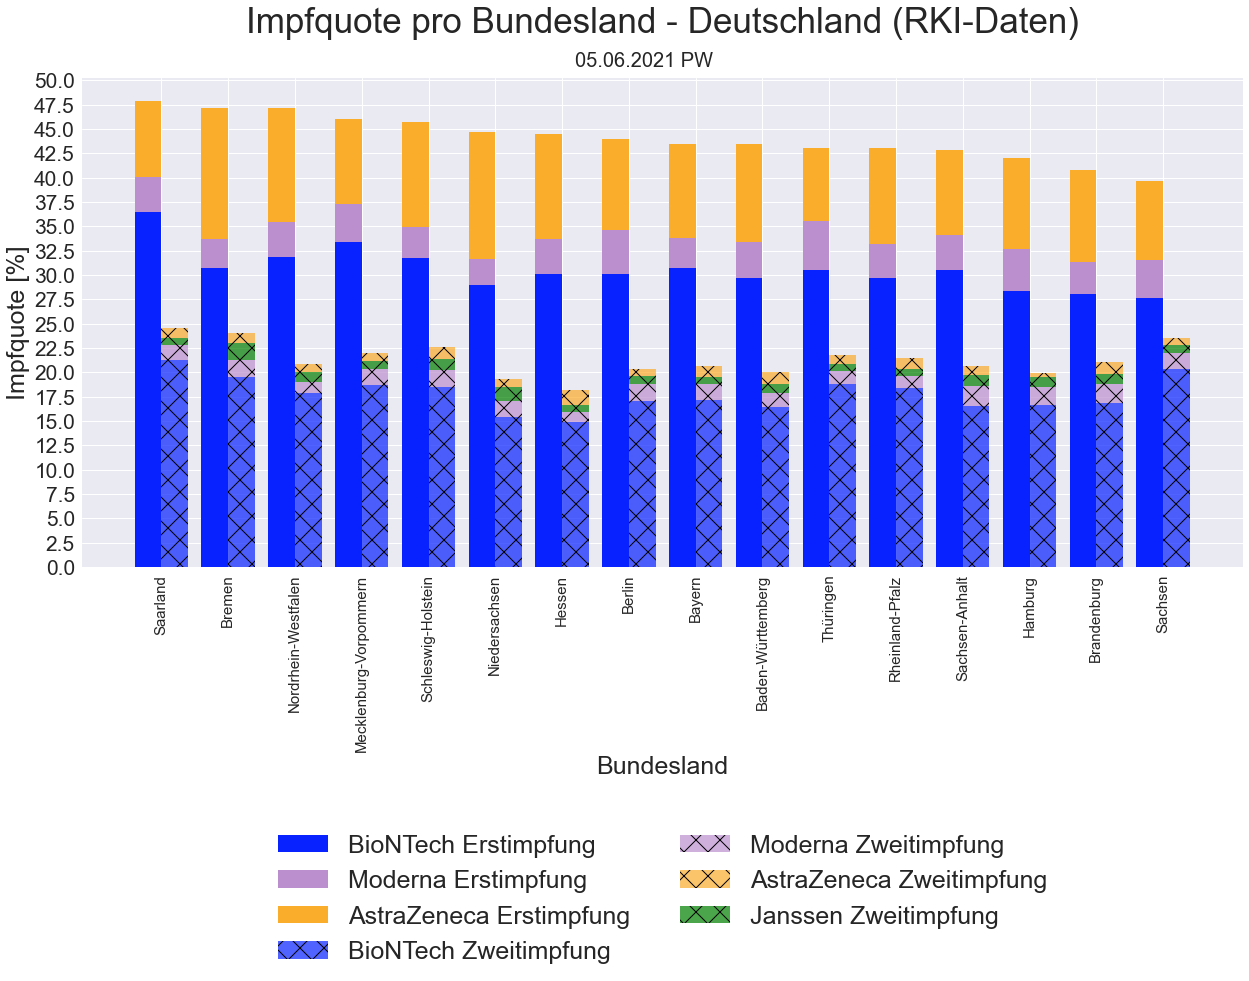

In [29]:
plt.figure(figsize=(h,v))

plt.style.use('seaborn')


w=0.40

x=df_I_EW["Bundesland"].tolist()
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]


p1 = plt.bar(x=bar1, height=df_I_EW["Impfquote_BioNTech_EI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Erstimpfung")

p2 = plt.bar(x=bar1, height=df_I_EW["Impfquote_Moderna_EI"], width = 0.4, 
             align = 'center', color = c_cz, 
             bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Moderna Erstimpfung")

p3 = plt.bar(x=bar1, height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.4,
             align = 'center', color = c_gb, 
             bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), 
             label = "AstraZeneca Erstimpfung")



p4 = plt.bar(x=bar2, height=df_I_EW["Impfquote_BioNTech_ZI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Zweitimpfung", hatch="x", alpha = 0.7)

p5 = plt.bar(x=bar2, height=df_I_EW["Impfquote_Moderna_ZI"], width = 0.4, 
             align = 'center', color = c_cz, hatch="x", alpha = 0.7,
             bottom=df_I_EW["Impfquote_BioNTech_ZI"], label = "Moderna Zweitimpfung")

p6 = plt.bar(x=bar2, height=df_I_EW["Impfquote_AstraZeneca_ZI"], width = 0.4, ###
             align = 'center', color = c_gb, hatch="x", alpha = 0.7,
             bottom=  np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]) + np.array(df_I_EW["Impfquote_Janssen_ZI"]), 
             label = "AstraZeneca Zweitimpfung")

p7 = plt.bar(x=bar2, height=df_I_EW["Impfquote_Janssen_ZI"], width = 0.4, 
             align = 'center', color = "green", hatch="x", alpha = 0.7,
             bottom = np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]), 
             label = "Janssen Zweitimpfung")

# p6 = plt.bar(x=bar2, height=df_I_EW["Impfquote_AstraZeneca_ZI"], width = 0.4, ###
#              align = 'center', color = c_gb, alpha =0.7
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]), 
#              label = "AstraZeneca Zweitimpfung")






# p2 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_Moderna_EI"], width = 0.9, 
#              align = 'center', color = c_cz, 
#              bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Impfquote Moderna Erstimpfung")

# p3 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.9, ###
#              align = 'center', color = c_gb, 
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), label = "Impfquote AstraZeneca Erstimpfung")

# p4 = plt.bar(x=bar2, height=df_I_EW["Impfquote_ZI"], width = 0.4, 
#              align = 'center', color = c_at, 
#              label = "Impfquote Zweitimpfung")

# # Schriftgrößen x und y achsenwerte
plt.xticks(bar1+w/2, x,fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.yticks(np.arange(0, df_I_EW["Impfquote_EI"].max() +2.5 , 2.5))


plt.ylabel('Impfquote [%]', fontsize=size)
plt.xlabel('Bundesland', fontsize=size)

plt.title('Impfquote pro Bundesland - Deutschland (RKI-Daten)\n', fontsize=size+10)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.5),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(Laufwerk + pfad_output + name_7, dpi = dpi, bbox_inches='tight')
plt.savefig(Laufwerk + pfad_onedrive + name_7, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

In [30]:
# # def y_axis_thousands(x, pos):
# #    # 'The two args are the value and tick position'
# #     return '{:0,d}'.format(int(x)).replace(",",".")
# # formatter = FuncFormatter(y_axis_thousands)


# # fig = plt.figure(figsize=(h,v))
# # ax = fig.add_subplot()
# # ax.yaxis.set_major_formatter(formatter)

# plt.figure(figsize=(h,v))

# plt.style.use('seaborn')

# p1 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_BioNTech_EI"], width = 0.9, 
#              align = 'center', color = c_ger, label = "Impfquote BioNTech Erstimpfung")

# p2 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_Moderna_EI"], width = 0.9, 
#              align = 'center', color = c_cz, 
#              bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Impfquote Moderna Erstimpfung")

# p3 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.9, ###
#              align = 'center', color = c_gb, 
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), label = "Impfquote AstraZeneca Erstimpfung")

# p4 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_ZI"], width = 0.9, 
#              align = 'center', color = c_at, 
#              bottom=np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]) + np.array(df_I_EW["Impfquote_AstraZeneca_EI"]), 
#              label = "Impfquote Zweitimpfung")

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 10, rotation=90)
# plt.yticks(fontsize=size -4)

# plt.yticks(np.arange(0, df_I_EW["Impfquote_EI_ZI"].max() +0.5 , 0.5))


# plt.ylabel('Anteil verabreichte Dosen [%]', fontsize=size)
# plt.xlabel('Bundesland', fontsize=size)

# plt.title('Anteil verabreichte Dosen - Deutschland (RKI-Daten)\n', fontsize=size)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.5),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# # plt.text(x, y, f'Anteil verabreichte Dosen Deutschland : {Impfquote_ger}%\n (Verabreichte Dosen)', 
# #         horizontalalignment='center', 
# #         size=size-4, 
# #         style='italic',
# #         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})


# # korrigierte Hochrechnung mit exp model machen 
# # plt.text(x, y, f'grobe Hochrechnung: 60% der Bevölkerung geimpft in \nca. {Herdenimmun} Jahren.\nImpfquote Deutschland: {Impfquote_ger}%', 
# #         horizontalalignment='center', 
# #         size=size-4, 
# #         style='italic',
# #         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# # Diagramm als Bild exporieren und Auflösung definieren
# plt.savefig(Laufwerk + pfad_output + name_7, dpi = dpi, bbox_inches='tight')
# plt.savefig(Laufwerk + pfad_onedrive + name_7, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

### df_I_EW (Impfquote)

In [31]:
# #df_I_EW.head(1)

In [32]:
# # Timeseries gestern einlesen
# df_I_timeseries1 = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_timeseries.csv')

In [33]:
#df_I_EW.head(3)

### Berechnung Herdeinimmunität

In [34]:
df_I_EW

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,...,AstraZeneca_ZI,Impfquote_AstraZeneca_ZI,Janssen_ZI,Impfquote_Janssen_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
11,Saarland,986887.0,360307,36.5094,34833,3.52958,77125,7.81498,210005,21.2795,...,9381,0.950565,7561,0.766146,472265,47.854,241987,24.5202,714252,72.3742
4,Bremen,681202.0,209381,30.737,19960,2.93011,92029,13.5098,133397,19.5826,...,7172,1.05284,11757,1.72592,321370,47.1769,164154,24.0977,485524,71.2746
9,Nordrhein-Westfalen,17947221.0,5718375,31.8622,641491,3.57432,2104624,11.7267,3208166,17.8756,...,149908,0.835271,185829,1.03542,8464490,47.1632,3742289,20.8516,12206779,68.0149
7,Mecklenburg-Vorpommern,1608138.0,537752,33.4394,61538,3.82666,140604,8.74328,301467,18.7463,...,13597,0.845512,14253,0.886305,739894,46.0094,354344,22.0344,1094238,68.0438
14,Schleswig-Holstein,2903773.0,922595,31.7723,91901,3.16488,312297,10.7549,537810,18.5211,...,36329,1.2511,31468,1.08369,1326793,45.692,656896,22.6222,1983689,68.3142
8,Niedersachsen,7993608.0,2314250,28.9513,219201,2.7422,1039041,12.9984,1234756,15.4468,...,62591,0.783013,115372,1.4433,3572492,44.6919,1544565,19.3225,5117057,64.0144
6,Hessen,6288080.0,1893827,30.1177,225349,3.58375,678933,10.7971,935696,14.8805,...,96623,1.53661,43755,0.69584,2798109,44.4986,1144059,18.1941,3942168,62.6927
2,Berlin,3669491.0,1105308,30.1216,166694,4.5427,342392,9.33078,627997,17.114,...,24636,0.671374,30916,0.842515,1614394,43.995,746439,20.3418,2360833,64.3368
1,Bayern,13124737.0,4037164,30.76,398571,3.03679,1272479,9.69527,2254364,17.1765,...,144918,1.10416,99971,0.761699,5708214,43.492,2709707,20.6458,8417921,64.1378
0,Baden-Württemberg,11100394.0,3291260,29.6499,417401,3.76024,1116433,10.0576,1821146,16.4061,...,140722,1.26772,98151,0.884212,4825094,43.4678,2228203,20.0732,7053297,63.541


In [35]:

# Impfstart = datetime.strptime('28.12.2020', '%d.%m.%Y')
# Tage_seit_Impfstart = (now-Impfstart).days
Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
# Impfgeschwindigkeit = (1/2)*Summe_Impfungen/Tage_seit_Impfstart
# Impfgeschwindigkeit_gestern = (1/2)*df_I_EW["Differenz zum Vortag"].sum()

# if Impfgeschwindigkeit_gestern > Impfgeschwindigkeit:
#     Impfgeschwindigkeit = (Impfgeschwindigkeit*0.2 + Impfgeschwindigkeit_gestern*0.8)
#     print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} IF-Statement')

# Herdenimmun = round((1/12)*(1/30)*(E_ger*0.6)*(1/(Impfgeschwindigkeit)),1)   # grobe Schätzung Zeit bis Herdenimmun



# print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')   # wie lange schon geimpft wird
print(f'Summe_Impfungen = {Summe_Impfungen}')
# print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} Mittelwert')
# print(f'Impfgeschwindigkeit_gestern = {Impfgeschwindigkeit_gestern}')
# print(f'E_ger = {E_ger}')   # Einwohner Deutschland
# print(f'Herdenimmun = {Herdenimmun} Jahren')

Summe_Impfungen = 54073044


In [36]:
# v=s/t    v = 83020000*0.6 / t

Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
print(f'Summe_Impfungen  = {Summe_Impfungen} Impfungen\n')


Ende = datetime.strptime('01.10.2021', '%d.%m.%Y')
Tage_bis_Oktober = (Ende - now).days
print(f'Tage_bis_Oktober = {Tage_bis_Oktober} Tage\n')

Impfungen80 = 2*(E_ger*0.8) - Summe_Impfungen
SOLL_Impfungen80 = int(Impfungen80*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen80 = {SOLL_Impfungen80} Impfungen pro Tag')
print(f'Impfungen80 = {Impfungen80} Impfungen\n')

Impfungen60 = 2*(E_ger*0.6) - Summe_Impfungen
SOLL_Impfungen60 = int(Impfungen60*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen60 = {SOLL_Impfungen60} Impfungen pro Tag')
print(f'Impfungen60 = {Impfungen60} Impfungen\n')

Impfungen30 = 2*(E_ger*0.3) - Summe_Impfungen
SOLL_Impfungen30 = int(Impfungen30*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen30 = {SOLL_Impfungen30} Impfungen pro Tag')
print(f'Impfungen30 = {Impfungen30} Impfungen\n')

# Impfungen15 = 2*(E_ger*0.15) - Summe_Impfungen
# SOLL_Impfungen15 = int(Impfungen15*(1/Tage_bis_Oktober))
# print(f'SOLL_Impfungen15 = {SOLL_Impfungen15} Impfungen pro Tag')
# print(f'Impfungen15 = {Impfungen15} Impfungen\n')

# Impfungen5 = 2*(E_ger*0.05) - Summe_Impfungen
# SOLL_Impfungen5 = int(Impfungen5*(1/Tage_bis_Oktober))
# print(f'SOLL_Impfungen5 = {SOLL_Impfungen5} Impfungen pro Tag')
# print(f'Impfungen5 = {Impfungen5} Impfungen\n')


Summe_Impfungen  = 54073044 Impfungen

Tage_bis_Oktober = 117 Tage

SOLL_Impfungen80 = 673153 Impfungen pro Tag
Impfungen80 = 78758956.0 Impfungen

SOLL_Impfungen60 = 389324 Impfungen pro Tag
Impfungen60 = 45550956.0 Impfungen

SOLL_Impfungen30 = -36419 Impfungen pro Tag
Impfungen30 = -4261044.0 Impfungen



## Herdenimmunität Exponentialmodell

In [37]:
#df_I_EW

In [38]:
# # P = I*(1+v)^t 
# # t = ln(P/I) * ( 1 / ln(1+v) )
# # wobei P die ZIEL geimpften, I die heute geimpften, v der Wachstumsfaktor und t die Zeit ist

# Ziel_Geimpfte = E_ger*0.6
# print(f'Ziel_Geimpfte {Ziel_Geimpfte}')

# Geimpfte_Heute = df_I_EW["Summe_EI_ZI"].sum()
# print(f'Geimpfte_Heute= {Geimpfte_Heute}')

# Wachstumsfaktor = (1/10) * df_I_TS["Summe_EI_ZI"].iloc[-1] / df_I_TS["Summe_EI_ZI"].iloc[-10]
# print(f'Wachstumsfaktor = {Wachstumsfaktor}')

# ##########################################################

# Anzahl_Impfzentren = 400
# Impfungen_pro_Tag_MAX = 400 * 1000

# Tage_seit_Impfstart
# print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')

# # logistic = MAX / (1+e^(-v*(x-x0))

# Zeit_Herdenimmun = np.log(Ziel_Geimpfte/Geimpfte_Heute) / (np.log(1+Wachstumsfaktor))
# print(f'Zeit_Herdenimmun = {Zeit_Herdenimmun}')

## df_I_TS Impfungen Timeseries

In [39]:
# df_I_TS

In [40]:
# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][3]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen
sheet_name

'Impfungen_proTag'

In [41]:
# df_I_TS

In [42]:


# Datenimport Impfungen
df_I_TS = pd.read_excel(Laufwerk + pfad_input + name_input,
                    sheet_name = sheet_name,
                    usecols="A:C")

df_I_TS = df_I_TS[:-6]   # drop last row
df_I_TS = df_I_TS.dropna(axis=0, how='any', thresh = 2)   # drop rows with more than 2 NaN values

df_I_TS['Erstimpfung'] = df_I_TS['Begonnene Impfserie']
df_I_TS['Zweitimpfung'] = df_I_TS['Vollständig geimpft']




df_I_TS['Zweitimpfung'] = df_I_TS['Zweitimpfung'].fillna(0)

df_I_TS['Summe_EI_ZI'] = df_I_TS['Erstimpfung'] + df_I_TS['Zweitimpfung']

# df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].ewm(alpha=0.5, adjust=False).mean()
df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).mean()

df_I_TS['MSTD_Impfungen'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).std()

df_I_TS['OTG_Impfungen'] = df_I_TS['MA'] + df_I_TS['MSTD_Impfungen']
df_I_TS['UTG_Impfungen'] = df_I_TS['MA'] - df_I_TS['MSTD_Impfungen']

df_I_TS['SOLL_Impfungen80'] = SOLL_Impfungen80
df_I_TS['SOLL_Impfungen60'] = SOLL_Impfungen60
df_I_TS['SOLL_Impfungen30'] = SOLL_Impfungen30
# df_I_TS['SOLL_Impfungen15'] = SOLL_Impfungen15
# df_I_TS['SOLL_Impfungen5'] = SOLL_Impfungen5

df_I_TS['cumsum_EI'] = df_I_TS['Erstimpfung'].cumsum()
df_I_TS['cumsum_ZI'] = df_I_TS['Zweitimpfung'].cumsum()

df_I_TS = df_I_TS.loc[df_I_TS.Erstimpfung >0, :] # nur Erstimpfungen > 0 anzeigen
#df_I_TS

In [43]:
df_I_TS

,Datum,Begonnene Impfserie,Vollständig geimpft,Erstimpfung,Zweitimpfung,Summe_EI_ZI,MA,MSTD_Impfungen,OTG_Impfungen,UTG_Impfungen,SOLL_Impfungen80,SOLL_Impfungen60,SOLL_Impfungen30,cumsum_EI,cumsum_ZI
0,2020-12-27 00:00:00,24085.0,NaN,24085.0,0.0,24085.0,24085.000000,NaN,NaN,NaN,673153,389324,-36419,24085.0,0.0
1,2020-12-28 00:00:00,18519.0,NaN,18519.0,0.0,18519.0,21302.000000,3935.756344,2.523776e+04,17366.243656,673153,389324,-36419,42604.0,0.0
2,2020-12-29 00:00:00,50129.0,NaN,50129.0,0.0,50129.0,30911.000000,16874.351306,4.778535e+04,14036.648694,673153,389324,-36419,92733.0,0.0
3,2020-12-30 00:00:00,62905.0,NaN,62905.0,0.0,62905.0,38909.500000,21112.393603,6.002189e+04,17797.106397,673153,389324,-36419,155638.0,0.0
4,2020-12-31 00:00:00,50051.0,NaN,50051.0,0.0,50051.0,41137.800000,18950.632633,6.008843e+04,22187.167367,673153,389324,-36419,205689.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2021-05-29 00:00:00,155407.0,254073.0,155407.0,254073.0,409480.0,679226.714286,354870.110064,1.034097e+06,324356.604222,673153,389324,-36419,35283645.0,14542929.0
154,2021-05-30 00:00:00,101441.0,184013.0,101441.0,184013.0,285454.0,678978.714286,355190.208372,1.034169e+06,323788.505913,673153,389324,-36419,35385086.0,14726942.0
155,2021-05-31 00:00:00,177340.0,358154.0,177340.0,358154.0,535494.0,708955.000000,328233.709973,1.037189e+06,380721.290027,673153,389324,-36419,35562426.0,15085096.0
156,2021-06-01 00:00:00,399161.0,572715.0,399161.0,572715.0,971876.0,754945.428571,340896.712028,1.095842e+06,414048.716543,673153,389324,-36419,35961587.0,15657811.0


In [44]:
# # Impfungen sheet_name der Datenquelle auslesen
# df_I_sheet = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx", None)
# sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
# sheet_name = [*sheet_name][2]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen

# # Datenimport Impfungen
# df_I_TS = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
#                     sheet_name = sheet_name,
#                     usecols="A:B")



#gleitender Mittelwert der cases und deaths, 7 Tage
# df_I_TS['MA'] = df_I_TS['Gesamtzahl Impfungen'].rolling(window=7,min_periods=1, center = False).mean()


# Date_reported in eine Datumsspalte umwandeln
#df_I_TS['Datum der Impfung'] = pd.to_datetime(df_I_TS.Date_reported, utc=True)
#df_I_TS = df_I_TS.dropna(axis=0, how='any')
#df_I_TS = df_I_TS[df_I_TS.Datum != 'Impfungen gesamt']

## RKI - Impfungen Timeseries

In [45]:
#df_I_TS.head(5)

## 7-2 Anzahl Impfungen - SOLL Impfungen - Timeseries

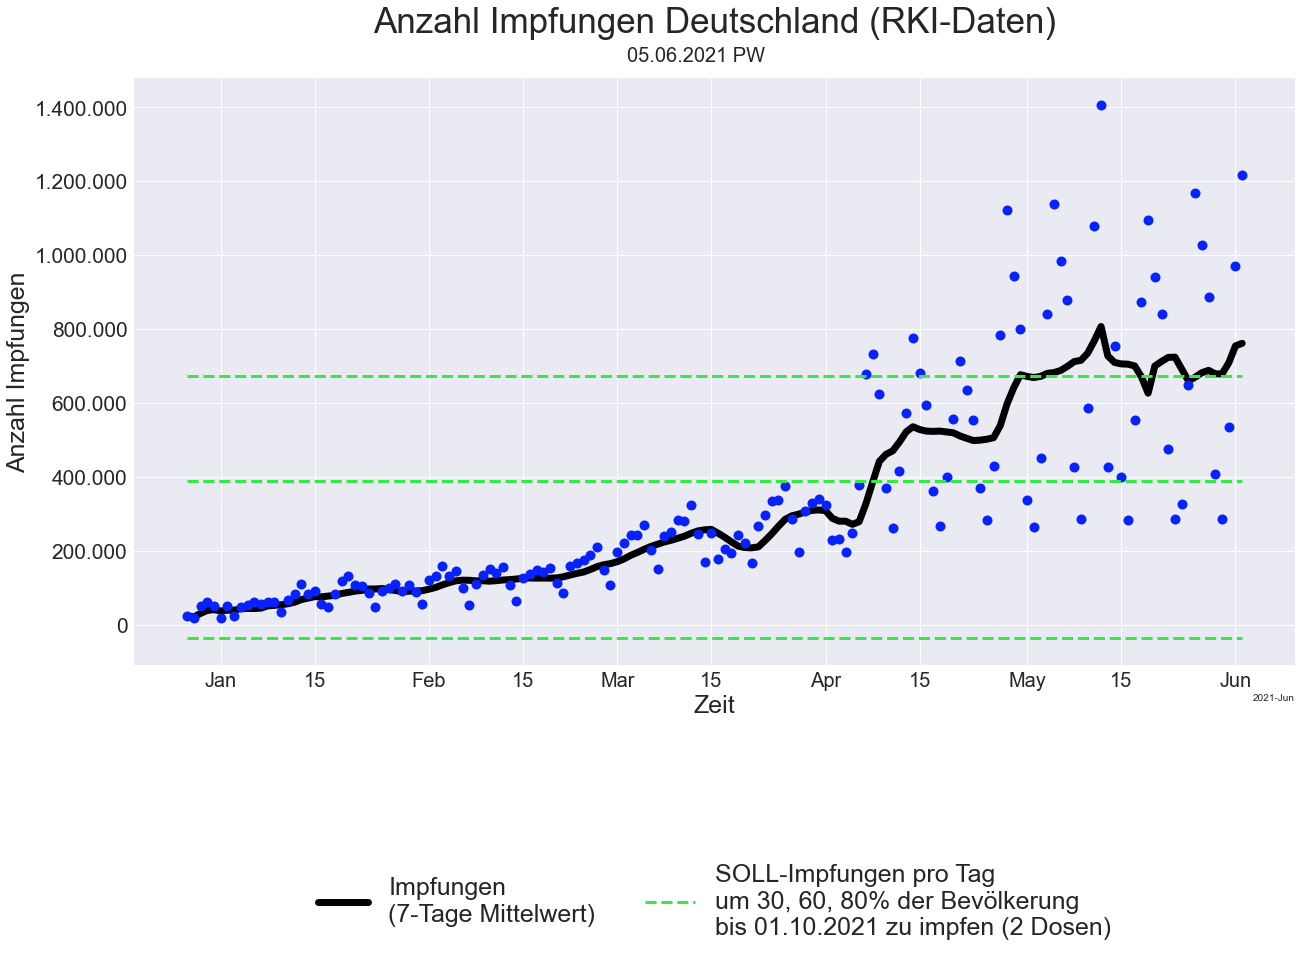

In [46]:

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)


fig, ax = plt.subplots(figsize=(h, v*1.2))

ax.yaxis.set_major_formatter(formatter)


# ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='.', markersize = 20, linestyle = 'solid', linewidth = lwb, 
#              label = "Impfungen\n(7-Tage Mittel)") # blau, linie, dick

ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color="black", linestyle = 'solid', linewidth = lwb, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

# ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="+- 1 sigma")
# ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="")

ax5 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen80'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "SOLL-Impfungen pro Tag\num 30, 60, 80% der Bevölkerung\nbis 01.10.2021 zu impfen (2 Dosen)")


ax6 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen60'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

ax7 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen30'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

# ax8 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen15'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "")

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# # fill area between lines
# plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_2, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_2, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## 7-3 Timeseries 

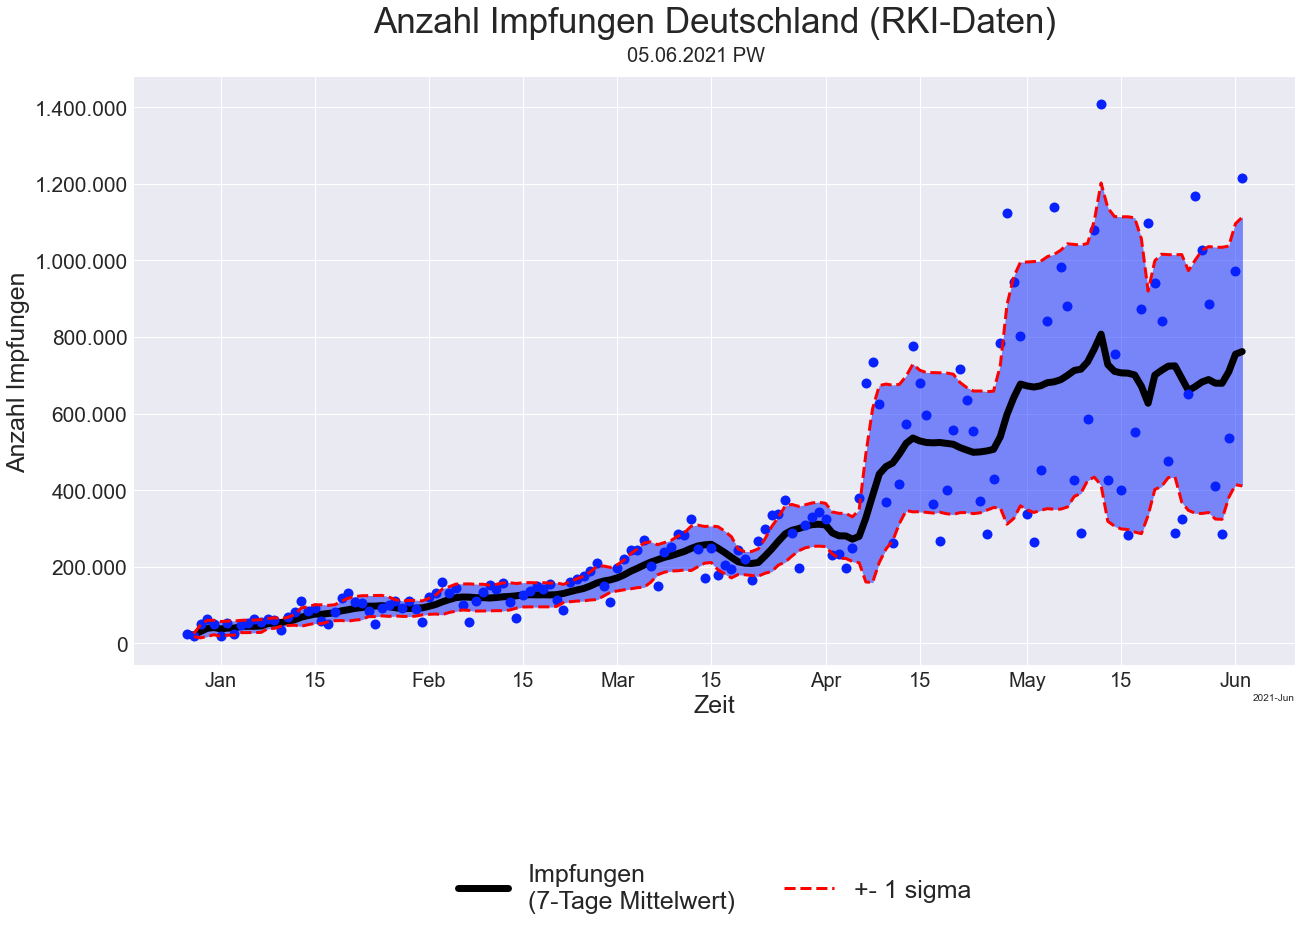

In [47]:

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)

fig, ax = plt.subplots(figsize=(h, v*1.2))

ax.yaxis.set_major_formatter(formatter)

ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color="black", linestyle = 'solid', linewidth = lwb, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
               label ="+- 1 sigma")

ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
               label ="")

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# # fill area between lines
plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color=c_ger,alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_3, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_3, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## Anzahl Impfungen kumuliert

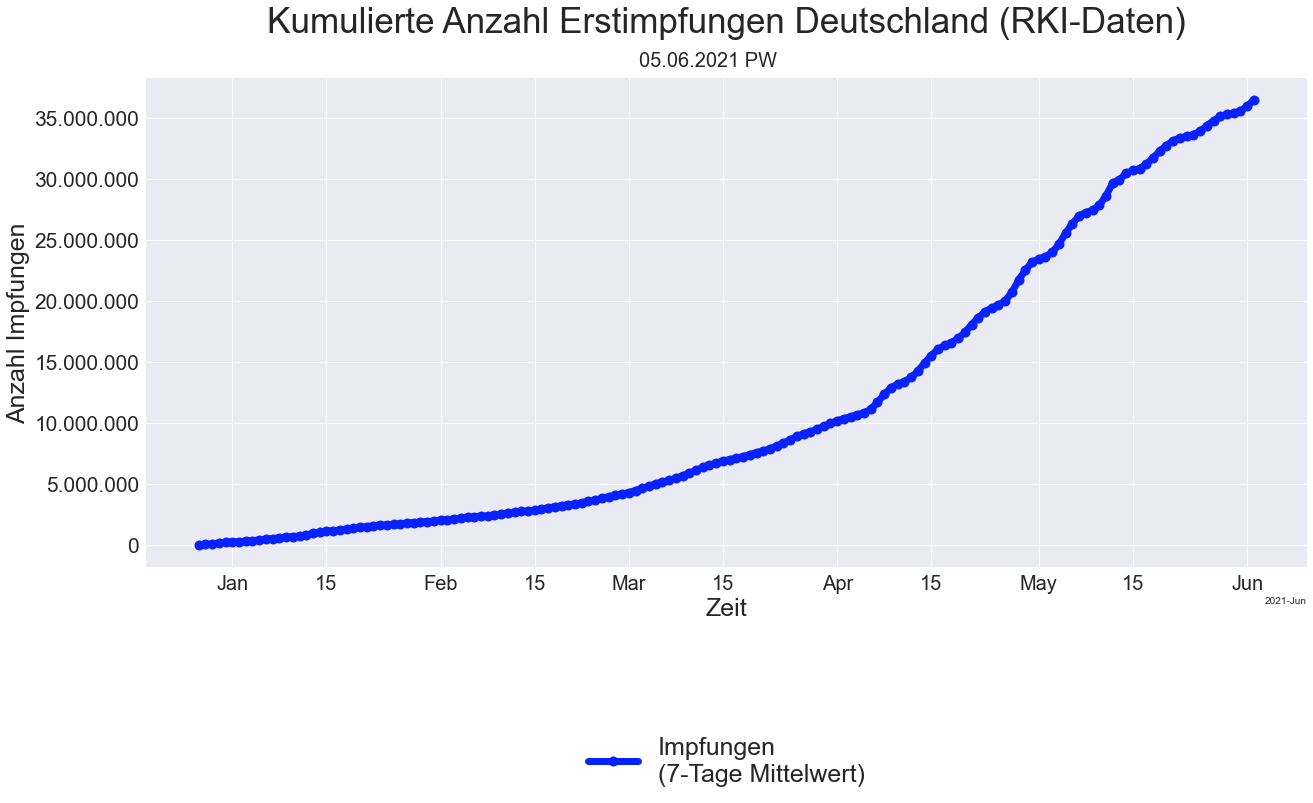

In [48]:
def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)


fig, ax = plt.subplots(figsize=(h, v))

ax.yaxis.set_major_formatter(formatter)


ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='.', markersize = 20, linestyle = 'solid', linewidth = lwb, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Kumulierte Anzahl Erstimpfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# # fill area between lines
# plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_4, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_4, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## dataframes speichern

In [49]:
df_EW.to_csv(Laufwerk + pfad_output + name_output_df_EW, index=False)
df_I.to_csv(Laufwerk + pfad_output + name_output_df_I, index=False)
df_I_EW.to_csv(Laufwerk + pfad_output + name_output_df_I_EW, index=False)
df_I_TS.to_csv(Laufwerk + pfad_output + name_output_df_I_TS, index=False)
# df_VOC.to_csv(Laufwerk + pfad_output + name_output_df_VOC, index=False)




## Performance messen

In [50]:
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

# Laufzeit
x = now2 - now
x = round(x.total_seconds(),2)

# Performance CSV einlesen
d = pd.read_csv(Laufwerk + pfad_output + name_performance)

# Neues Dateframe für die Performance definieren
now = datetime.now()

d2 = {'Date': [now],
      'PC': [pc],
      'Laufzeit_in_s': [x],
      'Version': [Programm_Name]}

# Datum Spalte formatieren
df2 = pd.DataFrame(d2)
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d %r')

# Performance mit dem CSV verbinden
d = d.append(df2, ignore_index=True)

# Datenexport Performance
d.to_csv(Laufwerk + pfad_output + name_performance, index=False)

print(f'performance {pc} = {x} seconds')

performance DOUG = 7.39 seconds
